<a href="https://colab.research.google.com/github/edugaspar/Brinquedos/blob/main/Toys2Cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing

First off, we'll need to decide on a dataset to use. Let's choose something that has a lot of really clear images to train on. The Stanford Cats and Dogs dataset is a very commonly used dataset, chosen for how simple yet illustrative the set is. You can download this right here.

Be sure to divide the dataset into two equally sized sets: "train" and "val".

You can do this anyway that you would like, by manually moving the files or by writing a function to handle it. You may also want to limit the dataset to a smaller size, as it comes with almost 12,000 images in each category, and this will take a long time to train. You may want to cut that number down to around 5000 in each category, with 1000 set aside for validation. However, the number of images you want to use for training is up to you.

Here's one way to prepare the data for use:

In [21]:
# !rm -rf cats-and-dogs/ val/ PetImages/ PetImagesPetImages/ PetImagesval/ # esse notebook se limpa automaticamente, remove pastas
!rm -rf sample_data

In [22]:
!mkdir /content/models/

mkdir: cannot create directory ‘/content/models/’: File exists


In [23]:
# início do wandb
!pip install wandb
!wandb login 1a7fc8ec61d3690ea8e5e449aa10f882a1c6b523

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [24]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="hmTyKjCIZStl2dvzzE5P")
project = rf.workspace("toys2cars").project("toys2cars")
dataset = project.version(5).download("folder")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to toys2cars-5 in folder:: 100%|██████████| 556/556 [00:00<00:00, 1401.97it/s]


# Loading the Data

After we have selected and prepared the data, we can start off by importing all the necessary libraries. We'll need many of the Torch packages like nn neural network, the optimizers and the DataLoaders. We'll also want matplotlib to visualize some of our training examples.

We need numpy to handle the creation of data arrays, as well as a few other miscellaneous modules:



In [25]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

To start off with, we need to load in our training data and prepare it for use by our neural network. We're going to be making use of Pytorch's transforms for that purpose. We'll need to make sure the images in the training set and validation set are the same size, so we'll be using transforms.Resize.

We'll also be doing a little data augmentation, trying to improve the performance of our model by forcing it to learn about images at different angles and crops, so we'll randomly crop and rotate the images.

Next, we'll make tensors out of the images, as PyTorch works with tensors. Finally, we'll normalize the images, which helps the network work with values that may be have a wide range of different values.

We then compose all our chosen transforms. Note that the validation transforms don't have any of the flipping or rotating, as they aren't part of our training set, so the network isn't learning about them:

In [26]:
# Make transforms and use data loaders   #fazendo transformações porem sobrescrevendo as originais com objetivo de aumentar a variabilidade

# We'll use these a lot, so make them variables
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]    

chosen_transforms = {'train': transforms.Compose([ # compose é um conjunto de coisas que estou executando em sequencia
        # transforms.RandomResizedCrop(size=256),
        # transforms.RandomRotation(degrees=15),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'valid': transforms.Compose([
        # transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]),
}

Now we will set the directory for our data and use PyTorch's ImageFolder function to create datasets:

In [27]:
# Set the directory for the data
data_dir = 'toys2cars-5/'

# Use the image folder function to create datasets
chosen_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), chosen_transforms[x]) for x in ['train', 'valid']} # criando um dataset

In [28]:
chosen_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 446
     Root location: toys2cars-5/train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'valid': Dataset ImageFolder
     Number of datapoints: 96
     Root location: toys2cars-5/valid
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

Now that we have chosen the image folders we want, we need to use the DataLoaders to create iterable objects for us to work with. We tell it which datasets we want to use, give it a batch size, and shuffle the data.

In [29]:
# Make iterables with the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size=4, # convertendo em um DataLoader para poder usar batch_size, shuffle
  shuffle=True, num_workers=4)
              for x in ['train', 'valid']}

In [30]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fef70788a50>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7fef7c4ced10>}

We're going to need to preserve some information about our dataset, specifically the size of the dataset and the names of the classes in our dataset. We also need to specify what kind of device we are working with, a CPU or GPU. The following setup will use GPU if available, otherwise CPU will be used:

In [31]:
dataset_sizes = {x: len(chosen_datasets[x]) for x in ['train', 'valid']}
class_names = chosen_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # pra rodar bem tem que ser GPU

In [32]:
print(dataset_sizes) # do DataLoader eu consigo extrair as informçoes ainda
print(class_names)

{'train': 446, 'valid': 96}
['CAR', 'FORMULA', 'KART', 'MOTO', 'TRUCK']


Now let's try visualizing some of our images with a function. We'll take an input, create a Numpy array from it, and transpose it. Then we'll normalize the input using mean and standard deviation. Finally, we'll clip values to between 0 and 1 so there isn't a massive range in the possible values of the array, and then show the image:

In [33]:
# Visualize some images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

Now let's use that function and actually visualize some of the data. We're going to get the inputs and the name of the classes from the DataLoader and store them for later use. Then we'll make a grid to display the inputs on and display them:

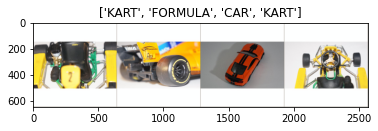

In [34]:
# Grab some of the training data to visualize
inputs, classes = next(iter(dataloaders['train']))

# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Setting up a Pretrained Model
Now we have to set up the pretrained model we want to use for transfer learning. In this case, we're going to use the model as is and just reset the final fully connected layer, providing it with our number of features and classes.

When using pretrained models, PyTorch sets the model to be unfrozen (will have its weights adjusted) by default. So we'll be training the whole model:

In [35]:
# Setting up the model   # definindo um modelo pre-treinado
# load in pretrained and reset final fully connected

res_mod = models.resnet34(pretrained=True) # modelo pre treinado que baixa pelo Pytorch

num_ftrs = res_mod.fc.in_features # fc - fool connected - camada totalmente conectada
res_mod.fc = nn.Linear(num_ftrs, 5) # numero de features de saída = 2

The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.


If this still seems somewhat unclear, visualizing the composition of the model may help.

In [36]:
for name, child in res_mod.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


Notice the final portion is fc, or "Fully-Connected". This is the only layer we are modifying the shape of, giving it our two classes to output.

Essentially, we're going to be changing the outputs of the final fully connected portion to just two classes, and adjusting the weights for all the other layers.

Now we need to send our model to our training device. We also need to choose the loss criterion and optimizer we want to use with the model. CrossEntropyLoss and the SGD optimizer are good choices, though there are many others.

We'll also be choosing a learning rate scheduler, which decreases the learning rate of the optimizer overtime and helps prevent non-convergence due to large learning rates. You can learn more about learning rate schedulers here if you are curious:

In [37]:
import wandb

wandb.init(project="Toys2Cars")


# agora vou começar a preparar meu algoritmo pro treinaamento
res_mod = res_mod.to(device) # convertendo pra GPU
criterion = nn.CrossEntropyLoss() # escolhendo a função de erro

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(res_mod.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs # definindo meu LR scheduler pra ele dimuir num fator 0.1 a cada 7 epocas
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

wandb.config = {
  "learning_rate": 0.001,
  "epochs": 10,
  "batch_size": 4
}

Now we just need to define the functions that will train the model and visualize the predictions.

Let's start off with the training function. It will take in our chosen model as well as the optimizer, criterion, and scheduler we chose. We'll also specify a default number of training epochs.

Every epoch will have a training and validation phase. To begin with, we set the model's initial best weights to those of the pretrained mode, by using state_dict.

Now, for every epoch in the chosen number of epochs, if we are in the training phase, we will:

1. Decrement the learning rate
2. Zero the gradients
3. Carry out the forward training pass
4. Calculate the loss
5. Do backward propagation and update the weights with the optimizer


We'll also be keeping track of the model's accuracy during the training phase, and if we move to the validation phase and the accuracy has improved, we'll save the current weights as the best model weights:

In [38]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):  # aqui esta o laço de treinamento
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
     

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode # se estou na fase de treinamento ele liber pra alterar os pesos
            else:
                model.eval()   # Set model to evaluate mode # no modo eval ele desabilita o treinamento
                                     # vou rodar 2 vezes, primeiro treino e depis avalio pra cada epoca
            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]: # interando sobre dataloaders
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # se tiver no modo de treinamento vou pegaar meu predict
                    _, preds = torch.max(outputs, 1) # aqui pego só o maior valor do meu predict
                    loss = criterion(outputs, labels) # calculo a perda baseada no predict e os labels e o y chapeu

                    # backward + optimize only if in training phase
                    if phase == 'train': # se tiver em treinamento se não tiver em treinamento não posso mexer nos pesos
                        loss.backward() # faço o backpropagation
                        optimizer.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0) # salvando os valores da perda 
                current_corrects += torch.sum(preds == labels.data) # somatoria de informações corretas em cada batch...

               
            epoch_loss = current_loss / dataset_sizes[phase] # para conseguir calcular a perda
            epoch_acc = current_corrects.double() / dataset_sizes[phase] # e a acurácia da época porque estou fazendo a validação tb

            # wandb----loop interno
            wandb.log({"loss": epoch_loss})
            # Optional
            wandb.watch(model)
            # wnadb fim----
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
           
             # Make a copy of the model if the accuracy on the validation set has improved #aqui faço a acurácia de validação
            if phase == 'valid' and epoch_acc > best_acc: # se minha epoca atual for melhor que minha melhor epoca 
                best_acc = epoch_acc                    # salvo minha epoca atual
                best_model_wts = copy.deepcopy(model.state_dict())  # salvo os pesos dessa melhor epoca olha p model.state_dict()
                            # pode ser que eu esteja em minimo global melhor caso mas com um LR grande então pode acabar saindo desse global caindo em um local...
        print()             # é como se eu fizer um early stop  e continuo a partir desse ponto com um LR menos    

       
    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best valid Acc: {:4f}'.format(best_acc))

       
    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts) # aqui eu faço um load do meu best_model
    return model

# Visualization
Now we'll create a function that will let us see the predictions our model has made.

In [39]:
def visualize_model(model, num_images=8): # o defaul do conjunto de imagens é igual a 8
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs) # aqui faço um predict
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]])) # imprimo o que predizeu e o correto
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Now we can tie everything together. We'll train the model on our images and show the predictions:

Epoch 0/5
----------
Iterating through data...
train Loss: 0.8788 Acc: 0.6973
Iterating through data...
valid Loss: 0.0990 Acc: 0.9896

Epoch 1/5
----------
Iterating through data...
train Loss: 0.2239 Acc: 0.9305
Iterating through data...
valid Loss: 0.0062 Acc: 1.0000

Epoch 2/5
----------
Iterating through data...
train Loss: 0.1183 Acc: 0.9596
Iterating through data...
valid Loss: 0.0030 Acc: 1.0000

Epoch 3/5
----------
Iterating through data...
train Loss: 0.0572 Acc: 0.9843
Iterating through data...
valid Loss: 0.0027 Acc: 1.0000

Epoch 4/5
----------
Iterating through data...
train Loss: 0.0277 Acc: 0.9955
Iterating through data...
valid Loss: 0.0007 Acc: 1.0000

Epoch 5/5
----------
Iterating through data...
train Loss: 0.0815 Acc: 0.9753
Iterating through data...
valid Loss: 0.0042 Acc: 1.0000

Training complete in 92m 57s
Best valid Acc: 1.000000


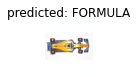

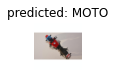

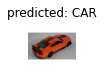

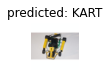

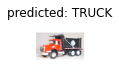

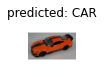

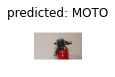

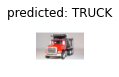

In [40]:
base_model = train_model(res_mod, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=6)
visualize_model(base_model)
plt.show()

That training will probably take you a long while if you are using a CPU and not a GPU. It will still take some time even if using a GPU.

# Fixed Feature Extractor
It is due to the long training time that many people choose to simply use the pretrained model as a fixed feature extractor, and only train the last layer or so. This significantly speeds up training time. In order to do that, you'll need to replace the model we've built. There will be a link to a GitHub repo for both versions of the ResNet implementation.

Replace the section where the pretrained model is defined with a version that freezes the weights and doesn't carry our gradient calculations or backprop.

It looks quite similar to before, except that we specify that the gradients don't need computation:

In [41]:
# Setting up the model
# Note that the parameters of imported models are set to requires_grad=True by default

res_mod = models.resnet34(pretrained=True)
for param in res_mod.parameters():
    param.requires_grad = False # desabilitndo o gradiente descendente na rede inteira pra depois habilitar apenas nas camadas que eu quero

num_ftrs = res_mod.fc.in_features
res_mod.fc = nn.Linear(num_ftrs, 5) # numero de categorias = 2

res_mod = res_mod.to(device)
criterion = nn.CrossEntropyLoss() # perd entropia crusada

# Here's another change: instead of all parameters being optimized
# only the params of the final layers are being optimized

optimizer_ft = optim.SGD(res_mod.fc.parameters(), lr=0.001, momentum=0.9) # otimizador SGD Gradiente Descendente Estocástico

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1) # depreciação do LR com scheduler

What if we wanted to selectively unfreeze layers and have the gradients computed for just a few chosen layers. Is that possible? Yes, it is.

Let's print out the children of the model again to remember what layers/components it has:

In [42]:
for name, child in res_mod.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


Now that we know what the layers are, we can unfreeze ones we want, like just layers 3 and 4:

In [43]:
for name, child in res_mod.named_children(): # for por todas as camadas - res_mod.named_children() são as camadas 
    if name in ['layer3', 'layer4']:         # descongelando apenas as Layer3 e layer4 isso é o transfer learning
        print(name + 'has been unfrozen.')
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

layer3has been unfrozen.
layer4has been unfrozen.


Of course, we'll also need to update the optimizer to reflect the fact that we only want to optimize certain layers.

In [44]:
# aqui estou redefinindo o otimizador para que ele atue somente nas camadas descongeladas
# para considerar as camadas só onde requires_grad = True
# faço um filtro lambda - é um for que est executando em todo res_mod.parameters() pega o x pra passar pro SGD
optimizer_conv = torch.optim.SGD(filter(lambda x: x.requires_grad, res_mod.parameters()), lr=0.001, momentum=0.9) 

Epoch 0/5
----------
Iterating through data...
train Loss: 0.2046 Acc: 0.9798
Iterating through data...
valid Loss: 0.0195 Acc: 1.0000

Epoch 1/5
----------
Iterating through data...
train Loss: 0.1465 Acc: 0.9843
Iterating through data...
valid Loss: 0.0138 Acc: 1.0000

Epoch 2/5
----------
Iterating through data...
train Loss: 0.1199 Acc: 0.9910
Iterating through data...
valid Loss: 0.0108 Acc: 1.0000

Epoch 3/5
----------
Iterating through data...
train Loss: 0.1000 Acc: 0.9910
Iterating through data...
valid Loss: 0.0084 Acc: 1.0000

Epoch 4/5
----------
Iterating through data...
train Loss: 0.0731 Acc: 0.9933
Iterating through data...
valid Loss: 0.0082 Acc: 1.0000

Epoch 5/5
----------
Iterating through data...
train Loss: 0.0865 Acc: 0.9933
Iterating through data...
valid Loss: 0.0047 Acc: 1.0000

Training complete in 64m 25s
Best valid Acc: 1.000000


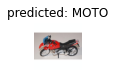

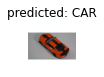

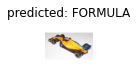

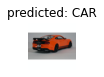

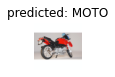

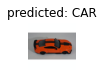

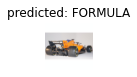

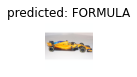

In [48]:
base_model = train_model(res_mod, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=6)
visualize_model(base_model)
plt.show()

In [49]:
torch.save(base_model.state_dict(), "/content/models/toys2cars_best.pt" ) # para salvar o melhor modelo

In [47]:
base_model.load_state_dict(torch.load("/content/models/toys2cars_best.pt")) # para carregar
base_model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

So now you know that you can tune the entire network, just the last layer, or something in between.

# Conclusion
Congratulations, you've now implemented transfer learning in PyTorch. It would be a good idea to compare the implementation of a tuned network with the use of a fixed feature extractor to see how the performance differs. Experimenting with freezing and unfreezing certain layers is also encouraged, as it lets you get a better sense of how you can customize the model to fit your needs.

Here's some other things you can try:

* Using different pretrained models to see which ones perform better under different circumstances
* Changing some of the arguments of the model, like adjusting learning rate and momentum
* Try classification on a dataset with more than two classes